In [12]:
# Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score

In [13]:
# Load the dataset
df = pd.read_csv('/Users/megankelly/ASDA/wine_development(in).csv', sep=',')
df.sample(5)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,color,wine_id
2064,6.3,0.39,0.22,2.8,0.048,53.0,173.0,0.99304,3.24,0.45,9.8,5,white,2205
2896,5.6,0.39,0.24,4.7,0.034,27.0,77.0,0.99060,3.28,0.36,12.7,5,white,690
628,5.9,0.62,0.28,3.5,0.039,55.0,152.0,0.99070,3.44,0.44,12.0,6,white,3422
1647,6.2,0.20,0.31,1.0,0.031,22.0,73.0,0.99035,3.24,0.52,11.3,6,white,1154
1087,8.9,0.30,0.35,4.6,0.032,32.0,148.0,0.99458,3.15,0.45,11.5,7,white,3697


In [14]:
# Check for outliers using OneClassSVM
from sklearn.svm import OneClassSVM
oc_svm = OneClassSVM(nu=0.05, kernel='rbf', gamma='scale')
outliers = oc_svm.fit_predict(df.select_dtypes(include=['float64', 'int64']))
df['outlier'] = outliers
print(f"Number of outliers detected: {(df['outlier'] == -1).sum()}")

Number of outliers detected: 209


In [15]:
# Handle outliers based on OneClassSVM results
df = df[df['outlier'] != -1]
df.drop('outlier', axis=1, inplace=True)

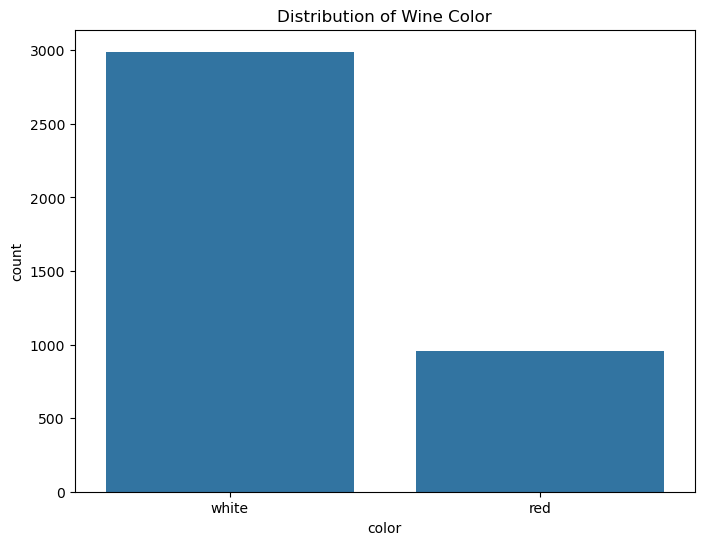

In [16]:
# Check for balanced classes
plt.figure(figsize=(8, 6))
sns.countplot(x='color', data=df)
plt.title("Distribution of Wine Color")
plt.show()

In [17]:
# Split dataset into training and testing sets
X = df.drop('color', axis=1)
y = df['color']

# Use a single stratified train/test split to create a stable holdout set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print('Train samples:', X_train.shape[0], 'Test samples:', X_test.shape[0])

Train samples: 3158 Test samples: 790


In [18]:
# Scale your features for visualization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

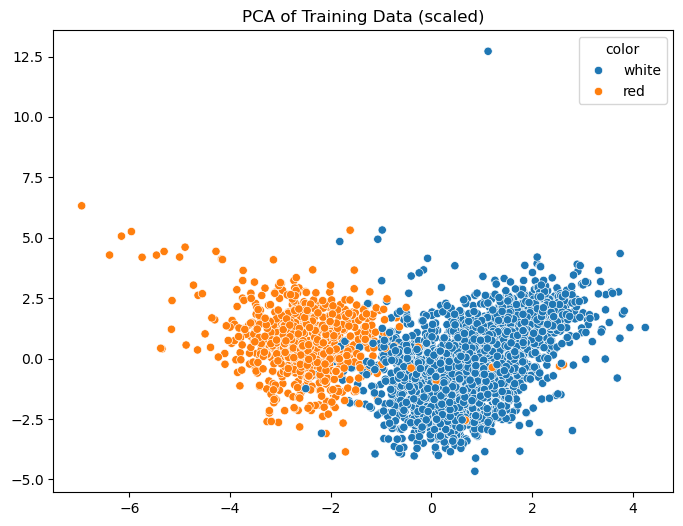

In [19]:
# PCA Visualization (use scaled features)
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
# use the scaled training data for PCA so components aren't dominated by scale
X_train_pca = pca.fit_transform(X_train_scaled)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_train_pca[:, 0], y=X_train_pca[:, 1], hue=y_train)
plt.title("PCA of Training Data (scaled)")
plt.show()

In [20]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# split once (stratify to preserve class balance)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC())
])

param_grid = {
    'svc__C': [0.01, 0.1, 1, 10],
    'svc__kernel': ['linear', 'rbf', 'poly'],
    'svc__gamma': ['scale', 'auto']
}

gs = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
gs.fit(X_train, y_train)

print("Best CV score:", gs.best_score_)
print("Test accuracy:", gs.score(X_test, y_test))
print("Test classification report:\n", classification_report(y_test, gs.predict(X_test)))

Best CV score: 0.9946157395333909
Test accuracy: 0.9974683544303797
Test classification report:
               precision    recall  f1-score   support

         red       1.00      0.99      0.99       192
       white       1.00      1.00      1.00       598

    accuracy                           1.00       790
   macro avg       1.00      0.99      1.00       790
weighted avg       1.00      1.00      1.00       790

